In [1]:
from splat.read_colmap import read_images_text, qvec2rotmat
from splat.gaussians import Gaussians
from splat.gaussian_scene import GaussianScene
import pycolmap
import torch 
import torch.nn as nn
import numpy as np

from splat.utils import read_images_text, read_images_binary

colmap_path = "treehill/sparse/0"
reconstruction = pycolmap.Reconstruction(colmap_path)

points3d = reconstruction.points3D
images = read_images_binary(f"{colmap_path}/images.bin")
cameras = reconstruction.cameras

all_points3d = []
all_point_colors = []

for idx, point in enumerate(points3d.values()):
    if point.track.length() >= 2:
        all_points3d.append(point.xyz)
        all_point_colors.append(point.color)

gaussians = Gaussians(
    torch.Tensor(all_points3d), 
    torch.Tensor(all_point_colors),
    model_path="point_clouds"
)
scene = GaussianScene(
    colmap_path=colmap_path,
    gaussians=gaussians,
)

/var/folders/5t/lqp_tbx57bl8lb0cbbxb2sv80000gn/T/ipykernel_74208/2940945277.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  torch.Tensor(all_points3d),


# Renders all points in the scene

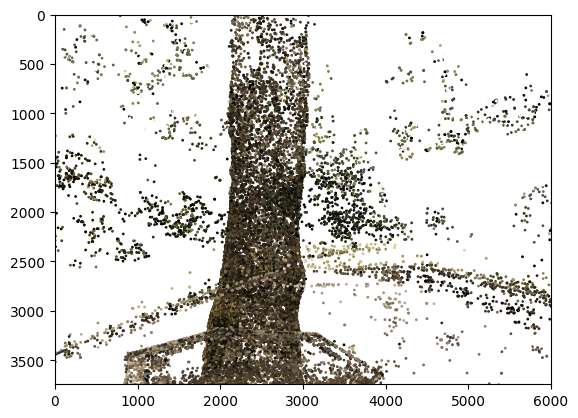

In [2]:
from matplotlib import pyplot as plt
image_num = 100

processed_scene = scene.preprocess(image_num)
plt.scatter(processed_scene.points_xy[:, 0].detach().cpu(), processed_scene.points_xy[:, 1].detach().cpu(), c=processed_scene.colors.detach().cpu(), s=1)
plt.xlim(0, 6000)
plt.ylim(0, 3744)
plt.gca().invert_yaxis() 

# Uses our render image - this may take a while without GPUs

In [2]:
# this may take a while

with torch.no_grad():
    image = scene.render_image(image_num)

plt.imshow(image.cpu().numpy())

NameError: name 'torch' is not defined

In [ ]:
with torch.no_grad():
    image = scene.render_image(image_num, tile_size = 16)
plt.imshow(image.detach().transpose(0, 1) * 256)